In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from keras.layers import *
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

import os
import cv2
import shutil

In [2]:

# Organising data
folder_path = "D:\\New folder"
folder_names = ["0","1"]

if not os.path.exists(folder_path):
    os.mkdir(folder_path)
else:
    print("Folder already exists...")

for folder_name in folder_names:
    if not os.path.exists(os.path.join(folder_path,folder_name)):
        os.mkdir(os.path.join(folder_path,folder_name))
    else:
        print("folder already exists...")

dataset = pd.read_csv("D:\\New folder\\Shoplifting1.csv")

# the datasets column names are also the part of the dataset
# first we will append that data into our dataframe and then rename the columns

data = [dataset.columns[0],dataset.columns[1],int(dataset.columns[2])]

dataset.loc[len(dataset)] = data

dataset.rename(columns={"Shoplifting001_x264_0":"clipname","Shoplifting":"Shoplifting","0":"Action"},inplace=True)

Folder already exists...
folder already exists...
folder already exists...


In [3]:
ROOT_DIR = r"D:\Dataset\DCSASS Dataset\Shoplifting"
DESTINATION_ROOT = r"D:\\New folder"
DESTINATION_PATH_0 = r"D:\\New folder\\0"
DESTINATION_PATH_1 = r"D:\\New folder\\1"

directories = os.listdir(ROOT_DIR)

for dir in directories:
    for d in os.listdir(os.path.join(ROOT_DIR,dir)):
            row = dataset.loc[dataset['clipname'] == d[:-4]]
            if row['Action'].iloc[0] == 0:
                shutil.copy(os.path.join(ROOT_DIR,dir,d),os.path.join(DESTINATION_PATH_0,d))
            else:
                shutil.copy(os.path.join(ROOT_DIR,dir,d),os.path.join(DESTINATION_PATH_1,d))

In [4]:
print("Count of number of video clips with 0 and 1 :-")
print(dataset['Action'].value_counts())
print("---------------------------------------------------------------------------------------")
print("Video clips present in 0 and 1 :-")
print("no shoplifting count : ",len(os.listdir(DESTINATION_PATH_0)))
print("shoplifting count : ",len(os.listdir(DESTINATION_PATH_1)))

Count of number of video clips with 0 and 1 :-
Action
0    741
1    155
Name: count, dtype: int64
---------------------------------------------------------------------------------------
Video clips present in 0 and 1 :-
no shoplifting count :  741
shoplifting count :  155


In [5]:

seed_constant = 27
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [6]:
dim = 64

IMAGE_HEIGHT = dim
IMAGE_WIDTH = dim

# Specify the number of frames that will be fed to the Neural Network
SEQUENCE_LENGTH = 30
CLASSES_LIST = ["0","1"]

In [7]:
def frame_extraction(video_path):
    
    frame_list = []

    video_capture = cv2.VideoCapture(video_path)
    video_frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frame_window = max(int(video_frame_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        # set the current frame position of the video
        video_capture.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frame_window)

        success,frame = video_capture.read()

        # check if the frame is successfully setup or not 
        if not success:
            break

        # Resize the frame into fixed size height and width
        resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))

        # Normalise the given frame
        normalized_frame = resized_frame/255

        # Append the normalised frame into  frame list
        frame_list.append(normalized_frame)

        # release the video capture object,
    video_capture.release()

    return frame_list



In [8]:
def create_dataset():
    features = []
    labels = []
    video_file_paths = []
    for cls_index,cls in enumerate(CLASSES_LIST):
        # Get the names of list of video files present in specific class name directory
        file_list = os.listdir(os.path.join(DESTINATION_ROOT,cls))

        for file in file_list:
            video_file_path = os.path.join(DESTINATION_ROOT,cls,file)
            frames = frame_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(cls_index)
                video_file_paths.append(video_file_path)

# Converting list into numpy array

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_file_paths

In [9]:
# create a dataset
features, labels, video_file_paths = create_dataset()

In [10]:
one_hot_encoded_labels = to_categorical(labels)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(features,one_hot_encoded_labels,test_size=0.25,shuffle=True,random_state=seed_constant)

In [12]:
# Creating Neural Network

input_layer = Input(shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3))

convlstm_1 = ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(input_layer)
pool1 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_1)
timedistributed_1 = TimeDistributed(Dropout(0.2))(pool1)

convlstm_2 = ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(timedistributed_1)
pool2 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_2)
timedistributed_2 = TimeDistributed(Dropout(0.2))(pool2)

convlstm_3 = ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(timedistributed_2)
pool3 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_3)
timedistributed_3 = TimeDistributed(Dropout(0.2))(pool3)

convlstm_4 = ConvLSTM2D(filters=32,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(timedistributed_3)
pool4 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_4)

flatten = Flatten()(pool4)

output = Dense(units=len(CLASSES_LIST), activation='softmax')(flatten)



model = Model(input_layer,output)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 30, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 30, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 30, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 30, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 30, 13, 13, 16) │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 30, 7, 7, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 30, 7, 7, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 30, 5, 5, 32)   │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 30, 3, 3, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8640)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        17,282 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,106 (355.88 KB)

 Trainable params: 91,106 (355.88 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)

In [15]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [16]:
history = model.fit(x_train,y_train,epochs=10,batch_size=4,shuffle=True, validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 161s 691ms/step - accuracy: 0.8047 - loss: 0.5894 - val_accuracy: 0.7926 - val_loss: 0.5035
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 85s 631ms/step - accuracy: 0.8310 - loss: 0.4655 - val_accuracy: 0.7926 - val_loss: 0.4960
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 83s 617ms/step - accuracy: 0.8310 - loss: 0.4601 - val_accuracy: 0.8074 - val_loss: 0.4651
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 83s 611ms/step - accuracy: 0.8332 - loss: 0.4582 - val_accuracy: 0.7556 - val_loss: 0.4639
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 610ms/step - accuracy: 0.8194 - loss: 0.4620 - val_accuracy: 0.7407 - val_loss: 0.4558
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 610ms/step - accuracy: 0.8227 - loss: 0.4343 - val_accuracy: 0.7704 - val_loss: 0.5703
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 77s 567ms/step - accuracy: 0.8356 - loss: 0.4263 - val_accuracy: 0.7778 - val_loss: 0.6169
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 75s 553ms/step - accuracy: 0.8247 - loss: 

In [17]:
model.save("model_2.h5")

In [18]:
loss,accuracy = model.evaluate(x_test,y_test)

print("Accuracy : ",accuracy)
print("Loss : ",loss)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 529ms/step - accuracy: 0.7692 - loss: 0.4514
Accuracy :  0.78125
Loss :  0.4527415931224823


In [19]:
# Plotting loss curve for training and validation set

def plot_curve(model_training_history,metric_name_1,metric_name_2,plot_name):
    
    metric1 = model_training_history.history[metric_name_1]
    metric2 = model_training_history.history[metric_name_2]
    plt.plot(metric1,color='blue',label=metric_name_1)
    plt.plot(metric2,color='red',label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()
    plt.show()

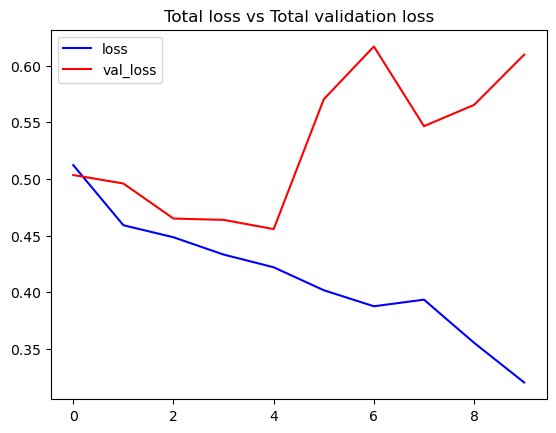

In [20]:
plot_curve(history,'loss','val_loss',"Total loss vs Total validation loss")

In [21]:
predictions = model.predict(x_test)

# Assuming predictions are in probability form and you need to convert them to binary labels
binary_predictions = (predictions > 0.5).astype('int32')

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, binary_predictions, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 546ms/step
Precision: [0.83251232 0.28571429]
Recall: [0.91847826 0.15      ]
F1 Score: [0.87338501 0.19672131]


Confusion Matrix

In [22]:
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # Assuming test_Y is one-hot encoded
conf_matrix = confusion_matrix(true_labels, predicted_labels)

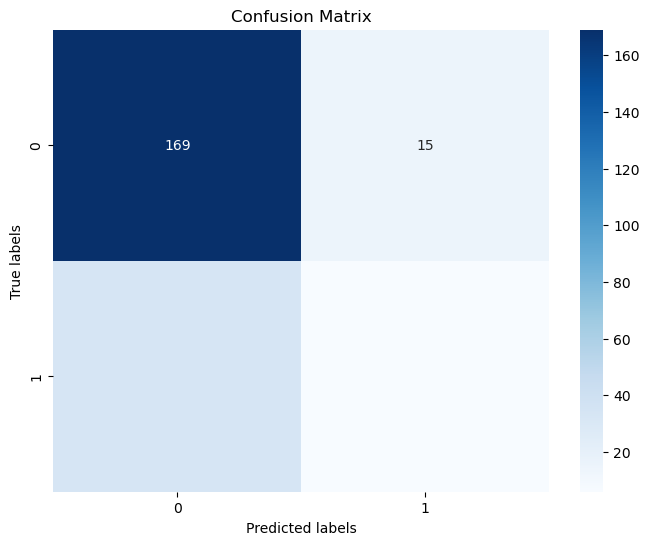

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import face_recognition
import os

# Load face recognition database
def load_criminal_database(database_path):
    known_face_encodings = []
    known_face_names = []

    if not os.path.exists(database_path):
        print("Database folder not found!")
        return known_face_encodings, known_face_names

    for file in os.listdir(database_path):
        if file.endswith(".jpg") or file.endswith(".png"):
            image_path = os.path.join(database_path, file)
            image = cv2.imread(image_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            encoding = face_recognition.face_encodings(image)
            if len(encoding) > 0:
                known_face_encodings.append(encoding[0])
                known_face_names.append(os.path.splitext(file)[0])
    return known_face_encodings, known_face_names

# Load the activity classification model
model = load_model("D:\\New folder\\model_2.h5")  # Update with your model path
frame_buffer = []

# Detect model output type
model_output_shape = model.output_shape
binary_sigmoid = (model_output_shape[-1] == 1)

# Define your classes
classes = ['normal', 'abnormal']

def preprocess_single_frame(frame):
    frame = cv2.resize(frame, (64, 64))  # Resize to model's expected input size
    frame = frame.astype(np.float32) / 255.0  # Normalize
    return frame

def classify_frame_sequence():
    input_sequence = np.array(frame_buffer)

    if input_sequence.shape != (30, 64, 64, 3):
        print(f"Invalid input sequence shape: {input_sequence.shape}")
        return "Unknown", 0.0

    input_sequence = np.expand_dims(input_sequence, axis=0)
    predictions = model.predict(input_sequence)
    
    print("Model predictions:", predictions)

    if binary_sigmoid:
        confidence = float(predictions[0][0])
        predicted_class = 'abnormal' if confidence >= 0.8 else 'normal'
    else:
        predicted_class_index = np.argmax(predictions[0])
        confidence = float(predictions[0][predicted_class_index])
        predicted_class = 'abnormal' if confidence >= 0.8 else 'normal'

    return predicted_class, confidence

# Load criminal database
database_path = "C:\\Users\\kirut\\Downloads\\criminal_databse"  # Update path
known_face_encodings, known_face_names = load_criminal_database(database_path)

# Start webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not access the camera.")
    exit()

print("Press 'q' to quit")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame.")
        break

    frame = cv2.flip(frame, 1)  # Mirror effect
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Face recognition
    face_locations = face_recognition.face_locations(rgb_frame)
    face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = "Unknown"

        if matches:
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

        # Draw rectangle around face and label it
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
        cv2.putText(frame, name, (left, top - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

    # Behavior classification
    preprocessed = preprocess_single_frame(frame)
    frame_buffer.append(preprocessed)

    if len(frame_buffer) > 30:
        frame_buffer.pop(0)

    if len(frame_buffer) == 30:
        predicted_class, confidence = classify_frame_sequence()
        label_text = f"{predicted_class} ({confidence:.2f})"
        color = (0, 255, 0) if predicted_class == 'normal' else (0, 0, 255)
        cv2.putText(frame, label_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Show the final frame
    cv2.imshow('Real-Time Criminal & Behavior Monitoring', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Press 'q' to quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Model predictions: [[0.8334593  0.16654073]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Model predictions: [[0.8214375  0.17856254]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Model predictions: [[0.8191073  0.18089268]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Model predictions: [[0.8140986  0.18590139]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Model predictions: [[0.81294405 0.1870559 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Model predictions: [[0.7990827  0.20091727]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Model predictions: [[0.757854 0.242146]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Model predictions: [[0.73496425 0.26503572]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Model predictions: [[0.7154495  0.28455052]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Model predictions: [[0.70271534 0.29728472]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Model predictions: [[0.6915818 0.3084182]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Model predictions: [[0.67492

KeyboardInterrupt: 